In [3]:
import numpy as np 
import pandas as pd

import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.corpus import stopwords
stop = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")

# DATA EXPLORATORY

In [4]:
df = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True) # Read dataset
df.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [5]:
df.dropna(subset=['headline'], inplace=True) # Remove null value
df.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [6]:
df['is_sarcastic'].value_counts() # Balanced

is_sarcastic
0    14985
1    11724
Name: count, dtype: int64

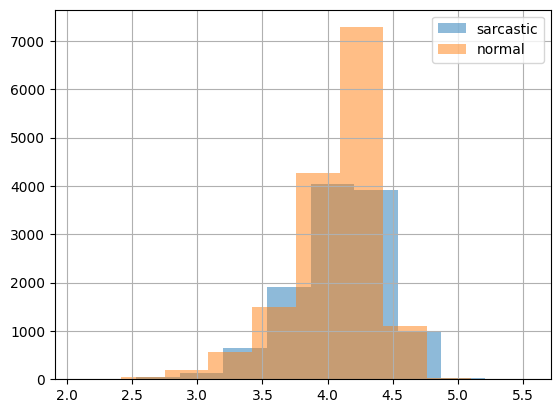

In [7]:
df_sarcasm = df.loc[df['is_sarcastic']==1, 'headline']
df_non_sarcasm = df.loc[df['is_sarcastic']==0, 'headline']

df_sarcasm.str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
df_non_sarcasm.str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend()

In [8]:
df = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True) # Read dataset
df.drop('article_link', axis='columns', inplace=True)
df_non_sarcasm = df[df['is_sarcastic']==0]
df_sarcasm = df[df['is_sarcastic']==1]

In [9]:
df_sarcasm.columns

Index(['headline', 'is_sarcastic'], dtype='object')

In [10]:
nlp.max_length = 300000 #Override the default allowed max length for a doc object
                                            
df_sarcasm = df_sarcasm.sample(5000, replace=False, random_state=1)
df_sarcasm['headline'] = df_sarcasm['headline'].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_sarcasm_text = df_sarcasm['headline'].tolist()
df_sarcasm_text = " ".join(df_sarcasm_text)

sarcasm_doc = nlp(df_sarcasm_text)


df_non_sarcasm  = df_non_sarcasm.sample(5000, replace=False, random_state=1)
df_non_sarcasm['headline'] = df_non_sarcasm['headline'].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_non_sarcasm_text = df_non_sarcasm['headline'].tolist()
df_non_sarcasm_text = " ".join(df_non_sarcasm_text)

non_sarcasm_doc = nlp(df_non_sarcasm_text)

In [11]:
for letter in sarcasm_doc:
    print(letter)

fitbit
releases
new
tracking
collar
gets
tighter
every
second
inactive
desktop
zen
rock
garden
thrown
assistant
horrified
pope
calls
philadelphia
humanity
's
greatest
sin
god
college
senior
holding
hope
internship
lead
class
-
action
lawsuit
'
please
feed
poor
'
campaign
catching
report
:
unclear
whether
opposition
every
sector
american
society
effect
healthcare
bill
passing
nude
aides
huddled
around
trump
assure
one
wearing
wire
man
chippewa
falls
,
wisconsin
hates
people
eagle
point
claim
chippewa
falls
no
-
makeup
look
easier
achieve
elle
claims
seating
mix
-
up
puts
tony
bennett
middle
slipknot
heaven
adds
guardrail
fifth
angel
plunges
edge
redundancy
built
tv
show
protect
failure
spoon
's
weight
topples
pint
jarring
reminder
much
ice
cream
area
man
ate
one
sitting
family
knows
interrupt
dad
he
's
skimming
pool
,
listening
orioles
radio
broadcast
every
intern
nonprofit
trying
solve
refugee
crisis
first
investigation
confirms
nbc
management
knowledge
misconduct
matt
lauer
's
network

In [12]:
def average(doc):
    average_word_length =sum(len(word) for word in doc) / len(doc)
    return (average_word_length)

print(f"Average word length of sarcastic headline: {average(sarcasm_doc)}")
print(f"Average word length of non sarcastic headline: {average(non_sarcasm_doc)}")

Average word length of sarcastic headline: 5.511989813963359
Average word length of non sarcastic headline: 5.197704237391623


In [13]:
sarcasmm_len = len(df_sarcasm['headline'].sum())
sarcasmm_len
non_sarcasm_len = len(df_non_sarcasm['headline'].sum())
non_sarcasm_len

242459

In [14]:
print(f"The average sentence length for sarcastic headline is: {sarcasmm_len/len(df_sarcasm)}")
print(f"The average sentence length for non sarcastic headline is: {non_sarcasm_len/len(df_non_sarcasm)}")

The average sentence length for sarcastic headline is: 53.2058
The average sentence length for non sarcastic headline is: 48.4918


In [15]:
def count_character_type(str):
    specialChar = 0
    for i in range(0, len(str)):
        ch = str[i]
        if ch == "!":
            specialChar+=1

    return specialChar

excl_count_sarcasm = count_character_type(df_sarcasm_text)
excl_count_non = count_character_type(df_non_sarcasm_text)

print(f"Count of exclamation marks for sarcastic headline: {excl_count_sarcasm}")
print(f"Count of exclamation marks for non sarcastic headline: {excl_count_non}")

Count of exclamation marks for sarcastic headline: 15
Count of exclamation marks for non sarcastic headline: 58


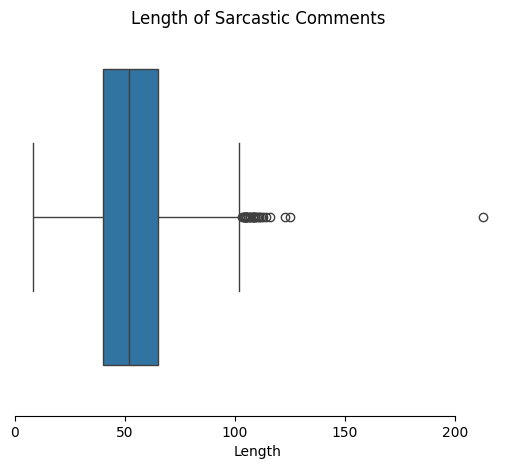

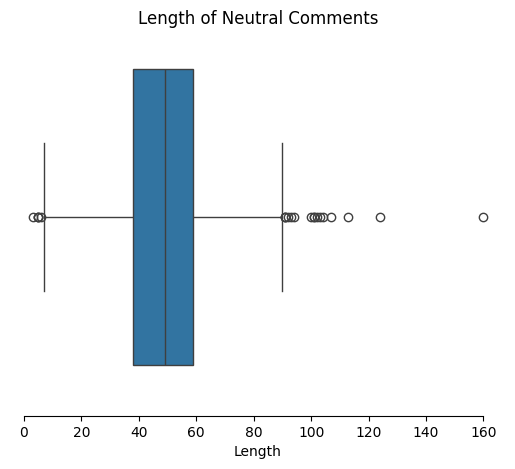

In [16]:
# Distribution of the lenth of Sarcastic comments
sns.boxplot(x= df_sarcasm['headline'].str.len()).set(title = 'Length of Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

# Distribution of the lenth of Neutral comments
sns.boxplot(x= df_non_sarcasm['headline'].str.len()).set(title = 'Length of Neutral Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

# Version1

TRAIN DATA

In [17]:
# split the dataset
X_train, X_test, Y_train, Y_test = train_test_split(df['headline'], df['is_sarcastic'], random_state=17)

In [18]:
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), ('logit', logit)])

In [19]:
tfidf_logit_pipeline.fit(X_train, Y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [20]:
pred = tfidf_logit_pipeline.predict(X_test)

In [21]:
print(f"The accuracy on the training set is: {tfidf_logit_pipeline.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {tfidf_logit_pipeline.score(X_test,Y_test)}")

The accuracy on the training set is: 0.9257151415306275
The accuracy on the test set is:  0.8447139862234202


In [22]:
testing_labels_final = np.array(Y_test) 
pred_label = np.array(pred)
print(classification_report(testing_labels_final, pred_label, target_names=['Not Sarcastic', 'Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.86      0.87      0.86      3805
    Sarcastic       0.83      0.81      0.82      2873

     accuracy                           0.84      6678
    macro avg       0.84      0.84      0.84      6678
 weighted avg       0.84      0.84      0.84      6678



In [23]:
# See test dataset
Test_df = pd.concat([X_test, Y_test], axis=1)
print(Test_df[df['is_sarcastic']==1].head(5))
print(Test_df[df['is_sarcastic']==0].head(5))

                                                headline  is_sarcastic
6997   lindsey graham asks nearby family to take his ...             1
7885    moronic mailroom worker worked way down from ceo             1
16883   jesus surprises 700 club with walk-on appearance             1
5308   boss wants to know if you can work late this year             1
608    area man going to go ahead and consider that a...             1
                                                headline  is_sarcastic
4818               5 ways to make cocoa more sustainable             0
1975   6 new jersey newspapers call on christie to re...             0
13548  canadian police probing stabbing and car attac...             0
22051  first amendment lawsuit says student was punis...             0
18850  5 reasons why you need boundaries in your rela...             0


C:\Users\gab22\AppData\Local\Temp\ipykernel_13484\176302221.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(Test_df[df['is_sarcastic']==1].head(5))
C:\Users\gab22\AppData\Local\Temp\ipykernel_13484\176302221.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(Test_df[df['is_sarcastic']==0].head(5))


In [27]:
from io import StringIO

while True:
    user_input = input("Enter a headline for prediction (or type 'exit' to quit): ") 
    if user_input.lower() == 'exit': 
        break
    input_df = pd.read_csv(StringIO(user_input))
    prediction = tfidf_logit_pipeline.predict(input_df)
    if prediction >= 0.5: 
        print(f"Headline: {user_input}\nPrediction: Sarcastic") 
    else: 
        print(f"Headline: {user_input}\nPrediction: Not Sarcastic")

Headline: Groundbreaking Study Reveals Water is Wet
Prediction: Not Sarcastic
Headline: New Study Shows Benefits of Regular Exercise on Mental Health
Prediction: Sarcastic
Headline: boss wants to know if you can work late this year
Prediction: Not Sarcastic


EmptyDataError: No columns to parse from file

# Version2

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(df['headline'].astype(str),df['is_sarcastic'],random_state=42)
lr_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))),
                   ('clf',  LogisticRegression(random_state= 42, solver='liblinear'))])
lr_clf.fit(X_train,Y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(random_state=42, solver='liblinear'))])

In [26]:
print(f"The accuracy on the training set is: {lr_clf.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {lr_clf.score(X_test,Y_test)}")

The accuracy on the training set is: 0.9483300883630373
The accuracy on the test set is:  0.8477088948787062
